<a href="https://colab.research.google.com/github/arushithapar/102117101-SESS_LE1/blob/main/102117101_ArushiDhingra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Download and extract the correct Speech Commands v0.02 dataset
!wget http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz
!tar -xvzf speech_commands_v0.02.tar.gz

In [ ]:
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Path to the main directory where the files were extracted
data_dir = './'

# List of directories (commands) to include in the analysis
commands = os.listdir(data_dir)
valid_commands = [cmd for cmd in commands if os.path.isdir(os.path.join(data_dir, cmd))
                  and cmd not in ['.', '..', '.config', 'background_noise', '.ipynb_checkpoints', 'sample_data']]


In [ ]:
# Function to analyze dataset and gather additional metrics
def analyze_dataset(data_dir, commands):
    durations = []
    sample_rates = []
    files_per_command = {}
    snr_values = []

    for command in commands:
        command_dir = os.path.join(data_dir, command)
        audio_files = [f for f in os.listdir(command_dir) if f.endswith('.wav')]

        files_per_command[command] = len(audio_files)

        for file in audio_files:
            file_path = os.path.join(command_dir, file)
            y, sr = librosa.load(file_path, sr=None)

            # Calculate duration and sample rate
            durations.append(librosa.get_duration(y=y, sr=sr))
            sample_rates.append(sr)

            # Calculate Signal-to-Noise Ratio (SNR)
            signal_power = np.mean(y ** 2)
            noise_power = np.var(y - np.mean(y))
            snr = 10 * np.log10(signal_power / (noise_power + 1e-10))
            snr_values.append(snr)

    return np.array(durations), np.array(sample_rates), files_per_command, np.array(snr_values)

Total commands (words): 36
Total audio files: 105835
Average duration: 0.98 seconds
Average sample rate: 16000.00 Hz
Max duration: 95.18 seconds
Min duration: 0.21 seconds
Average SNR: 0.07 dB
Max SNR: 37.81 dB
Min SNR: -0.00 dB


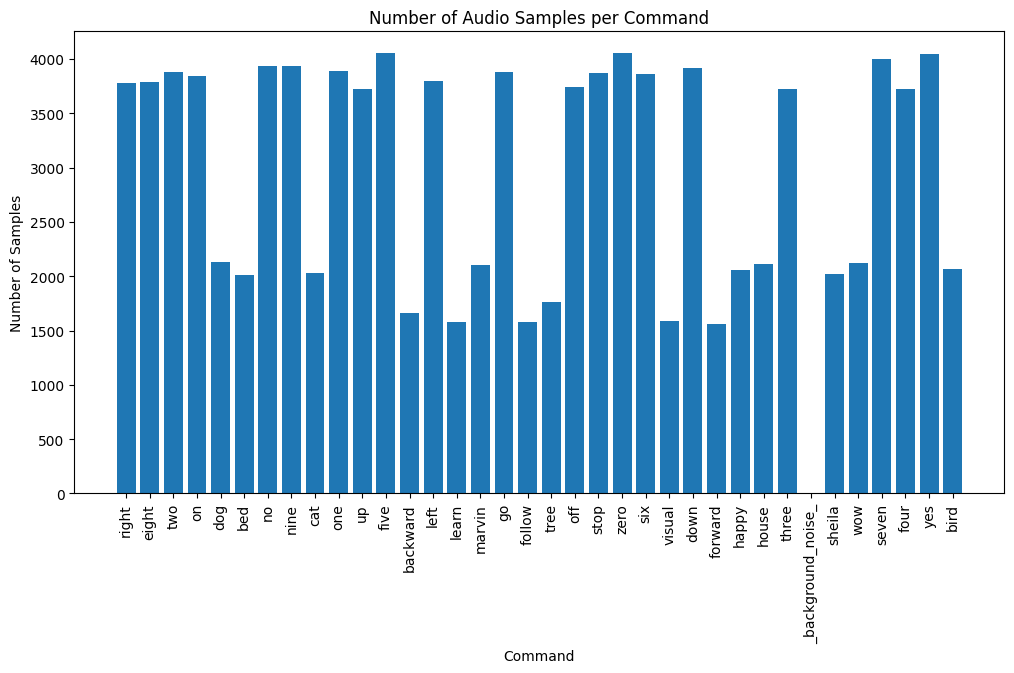

In [ ]:
# Get dataset statistics
durations, sample_rates, files_per_command, snr_values = analyze_dataset(data_dir, valid_commands)

# Print statistics
print(f"Total commands (words): {len(valid_commands)}")
print(f"Total audio files: {sum(files_per_command.values())}")
print(f"Average duration: {np.mean(durations):.2f} seconds")
print(f"Average sample rate: {np.mean(sample_rates):.2f} Hz")
print(f"Max duration: {np.max(durations):.2f} seconds")
print(f"Min duration: {np.min(durations):.2f} seconds")

# Print Signal-to-Noise Ratio statistics
print(f"Average SNR: {np.mean(snr_values):.2f} dB")
print(f"Max SNR: {np.max(snr_values):.2f} dB")
print(f"Min SNR: {np.min(snr_values):.2f} dB")

# Plot distribution of files per command
plt.figure(figsize=(12, 6))
plt.bar(files_per_command.keys(), files_per_command.values())
plt.title('Number of Audio Samples per Command')
plt.xlabel('Command')
plt.ylabel('Number of Samples')
plt.xticks(rotation=90)
plt.show()

In [ ]:
import librosa.display

# Function to compute and return mel-spectrogram statistics
def compute_mel_spectrogram_stats(file_path):
    y, sr = librosa.load(file_path, sr=None)
    mel_spec = librosa.feature.melspectrogram(y=y, sr=sr)
    log_mel_spec = librosa.power_to_db(mel_spec, ref=np.max)

    # Compute mel-spectrogram statistics
    mean = np.mean(log_mel_spec)
    std = np.std(log_mel_spec)

    return mean, std

# Update the analyze_dataset function to include mel-spectrogram statistics
def analyze_dataset(data_dir, commands):
    durations = []
    sample_rates = []
    files_per_command = {}
    snr_values = []
    mel_spectrogram_means = []
    mel_spectrogram_stds = []

    for command in commands:
        command_dir = os.path.join(data_dir, command)
        audio_files = [f for f in os.listdir(command_dir) if f.endswith('.wav')]

        files_per_command[command] = len(audio_files)

        for file in audio_files:
            file_path = os.path.join(command_dir, file)
            y, sr = librosa.load(file_path, sr=None)

            # Calculate duration and sample rate
            durations.append(librosa.get_duration(y=y, sr=sr))
            sample_rates.append(sr)

            # Calculate Signal-to-Noise Ratio (SNR)
            signal_power = np.mean(y ** 2)
            noise_power = np.var(y - np.mean(y))
            snr = 10 * np.log10(signal_power / (noise_power + 1e-10))
            snr_values.append(snr)

            # Calculate mel-spectrogram statistics
            mel_mean, mel_std = compute_mel_spectrogram_stats(file_path)
            mel_spectrogram_means.append(mel_mean)
            mel_spectrogram_stds.append(mel_std)

    return (np.array(durations), np.array(sample_rates), files_per_command,
            np.array(snr_values), np.array(mel_spectrogram_means), np.array(mel_spectrogram_stds))



Average Mel-Spectrogram Mean: -57.00
Average Mel-Spectrogram Std Dev: 17.34
Max Mel-Spectrogram Mean: -9.04
Min Mel-Spectrogram Mean: -78.27
Max Mel-Spectrogram Std Dev: 26.47
Min Mel-Spectrogram Std Dev: 2.20


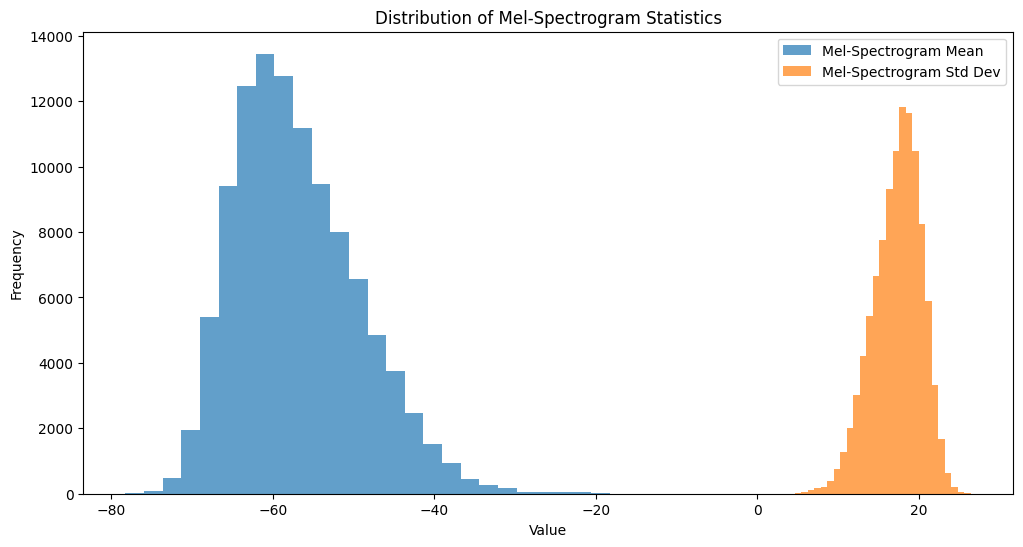

In [ ]:
# Compute mel-spectrogram statistics
durations, sample_rates, files_per_command, snr_values, mel_means, mel_stds = analyze_dataset(data_dir, valid_commands)

# Print Mel-Spectrogram statistics
print(f"Average Mel-Spectrogram Mean: {np.mean(mel_means):.2f}")
print(f"Average Mel-Spectrogram Std Dev: {np.mean(mel_stds):.2f}")
print(f"Max Mel-Spectrogram Mean: {np.max(mel_means):.2f}")
print(f"Min Mel-Spectrogram Mean: {np.min(mel_means):.2f}")
print(f"Max Mel-Spectrogram Std Dev: {np.max(mel_stds):.2f}")
print(f"Min Mel-Spectrogram Std Dev: {np.min(mel_stds):.2f}")

# Plot distribution of mel-spectrogram means and stds
plt.figure(figsize=(12, 6))
plt.hist(mel_means, bins=30, alpha=0.7, label='Mel-Spectrogram Mean')
plt.hist(mel_stds, bins=30, alpha=0.7, label='Mel-Spectrogram Std Dev')
plt.legend()
plt.title('Distribution of Mel-Spectrogram Statistics')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()
